In [41]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
import scipy
from scipy.integrate import odeint
import csv

In [43]:
Ad      = 4.4e16
Ed      = 140.06e3
Ap      = 1.7e11/60
Ep      = 16.9e3/0.239
deltaHp = -82.2e3
UA      = 33.3083 #%18.8445;
Qc      = 650
Qs      = 12.41e-2
V       = 0.5
Tc      = 27
Tamb    = 27
Cpc     = 4.184
R       = 8.3145
alpha   = 1.212827
beta    = 0.000267
epsilon = 0.5
theta   = 1.25
m1      = 450
cp1     = 4.184
mjCpj   = (18*4.184)+(240*0.49)
cp2     = 187
cp3     = 110.58 #%J/molK
cp4     = 84.95
m5      = 220
cp5     = 0.49
m6      = 7900
cp6     = 0.49
M0      = 0.7034
I0      = 4.5e-3

# Define Batch Reactor model
def br(x,t,u,Ad):
    # Inputs:
    # Coolant flow rate
    F = u*16.667

    # States (4):
    # Initiator
    Ii  = x[0]
    # Monomer
    M  = x[1]
    # Reactor temperature
    Tr = x[2]
    # Jacket temperature
    Tj = x[3]

    Ri    = Ad*Ii*(np.exp(-Ed/(R*(Tr+273.15))))
    Rp    = Ap*(Ii**epsilon)*(M**(theta)*(np.exp(-Ep/(R*(Tr+273.15)))))
    mrCpr = m1*cp1+ Ii*cp2*V + M*cp3*V +(M0-M)*cp4*V+ m5*cp5 + m6*cp6
    Qpr   = alpha*(Tr-Tc)**beta

    # Computing the rate of change of I, M, Tr, Tj using Differential Equations
    dy1_dt = -Ri
    dy2_dt = -Rp
    dy3_dt = (Rp*V*(-deltaHp)-UA*(Tr-Tj)+Qc+Qs-Qpr)/mrCpr
    dy4_dt = (UA*(Tr-Tj)-F*Cpc*(Tj-Tc))/mjCpj

    # Return xdot:
    xdot = np.zeros(4)
    xdot[0] = dy1_dt
    xdot[1] = dy2_dt
    xdot[2] = dy3_dt
    xdot[3] = dy4_dt

    return xdot



In [44]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
import scipy.integrate
import csv

class BR3(gym.Env):

    def __init__(self):
        self.action_space = spaces.Box(low=0.25, high=0.75, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=100, shape=(2,), dtype=np.float32)

        self.t = np.linspace(0, 7200, 7201)
        self.i = 0

        Tr_ref = pd.read_csv('C:/Users/Nagbhushan_Pai/Desktop/DeskTOP/Arasu work/batch_reactor/Trajectory2.csv')
        self.a1 = Tr_ref.values.tolist()
        self.sp = self.a1[self.i][0]

        # Initial conditions
        self.I = 4.5e-3
        self.M = 0.7034
        self.Tr = 45.0
        self.Tj = 40.0
        self.state = self.Tr, self.sp

        self.y0 = np.empty(4)
        self.y0[0] = self.I
        self.y0[1] = self.M
        self.y0[2] = self.Tr
        self.y0[3] = self.Tj

        self.time_step = 7200

    def step(self, action):
        action = action[0]
        u = action

        ts = [self.t[self.i], self.t[self.i+1]]
        y = scipy.integrate.odeint(br, self.y0, ts, args=(u, 4.4e16))
        x = np.round(y, decimals=4)

        self.I = x[-1][0]
        self.M = x[-1][1]
        self.Tr = x[-1][2]
        self.Tj = x[-1][3]

        self.y0 = np.array([self.I, self.M, self.Tr, self.Tj])

        # Data saving with overwrite logic
        data = [self.sp, self.Tr, self.Tj, action]
        mode = 'w' if self.i == 0 else 'a'
        with open('data.csv', mode, newline='') as file:
            writer = csv.writer(file)
            if self.i == 0:
                writer.writerow(['Setpoint', 'Reactor Temperature', 'Jacket Temperature', 'Action'])
            writer.writerow(data)

        self.i += 1
        if self.i < len(self.a1):
            self.sp = self.a1[self.i][0]

        difference = self.sp - self.Tr
        error = abs(difference)

        # Reward logic
        if error <= 0.5:
            self.reward = +100
        elif error <= 1:
            self.reward = +50
        elif error <= 3:
            self.reward = +25
        elif error <= 4:
            self.reward = +10
        else:
            self.reward = -100

        done = self.i >= self.time_step
        info = {}

        self.state = self.Tr, self.sp
        return self.state, self.reward, done, info

    def reset(self):
        self.I = 4.5e-3
        self.M = 0.7034
        self.Tr = 45.0
        self.Tj = 40.0
        self.i = 0

        self.sp = self.a1[self.i][0]
        self.state = self.Tr, self.sp

        self.y0 = np.array([self.I, self.M, self.Tr, self.Tj])

        return self.state


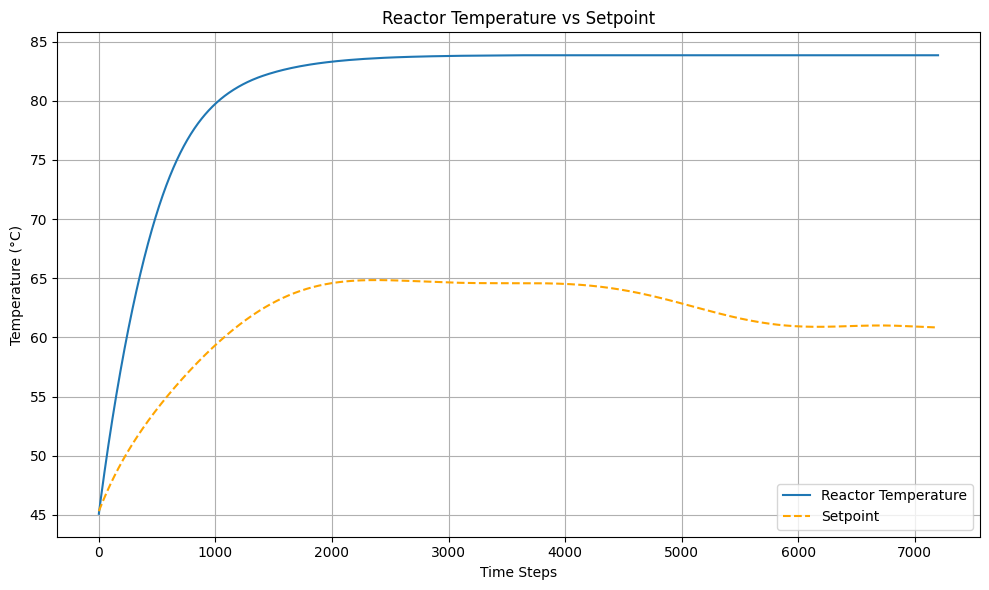

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the data
data = pd.read_csv('data.csv')  # Ensure this is the path you're writing to

# Create a time step axis (assuming 1 step per row)
time_steps = range(len(data))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_steps, data['Reactor Temperature'], label='Reactor Temperature')
plt.plot(time_steps, data['Setpoint'], label='Setpoint', linestyle='--', color='orange')

# Labels and title
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.title('Reactor Temperature vs Setpoint')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [45]:
env = BR3()
state = env.reset()
print(state)  # Should print initial (Tr, setpoint)
action = [0.5]  # Sample action
next_state, reward, done, info = env.step(action)
print(next_state, reward, done, info)

(45.0, 45.30756431)
(np.float64(45.0799), 45.33274461) 100 False {}


In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy

# Force CPU usage
device = torch.device("cpu")
print(f"Using device: {device}")

# Create a directory to save plots
output_dir = "training_plots"
os.makedirs(output_dir, exist_ok=True)

# Actor Network
class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, s):
        x = self.relu(self.fc1(s))
        x = self.relu(self.fc2(x))
        x = self.tanh(self.fc3(x)) * 0.25 + 0.5
        return x

# Critic Network
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, s, a):
        x = torch.cat([s, a], dim=-1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Initialize networks
P = 2
actors = [Actor().to(device) for _ in range(P)]
critics = [Critic().to(device) for _ in range(P)]
target_actors = [deepcopy(a).to(device) for a in actors]
target_critics = [deepcopy(c).to(device) for c in critics]

# ✅ FIX: Copy weights from actor[0]/critic[0] to actor[1]/critic[1]
actors[1].load_state_dict(actors[0].state_dict())
critics[1].load_state_dict(critics[0].state_dict())
target_actors[1].load_state_dict(target_actors[0].state_dict())
target_critics[1].load_state_dict(target_critics[0].state_dict())


# Replay buffers
replay_buffers = [[] for _ in range(P)]

# Optimizers
optimizers_actor = [optim.Adam(a.parameters(), lr=0.001) for a in actors]
optimizers_critic = [optim.Adam(c.parameters(), lr=0.001) for c in critics]

# Training parameters
L = 200 # Number of episodes
T = 7200  # Timesteps per episode
phase_bounds = [0, 4000, 7200]
gamma = 0.97
#Np = [1048576, 1048576]  # Batch size
Np=[512,512]  # Batch size
N = 512  # Number of samples per update
M = 10  # Number of updates

for episode in tqdm(range(L), desc="Training Episodes"):
    state = env.reset()
    episode_data = []
    v = np.random.normal(0, 0.1)

    # Collect experience
    for t in range(T):
        p = 0 if t < phase_bounds[1] else 1
        s_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        a_tensor = actors[p](s_tensor)
        action = a_tensor.detach().cpu().numpy()[0] + v
        action = np.clip(action, 0.25, 0.75)
        next_state, reward, done, _ = env.step([action])
        episode_data.append((state, action, reward, next_state, p))
        state = next_state
        if done:
            break

    # Compute discounted rewards
    G = []
    discounted_reward = 0
    for _, _, r, _, _ in reversed(episode_data):
        discounted_reward = r + gamma * discounted_reward
        G.insert(0, discounted_reward)

    # Store experiences in replay buffer
    for i, (s, a, _, _, p) in enumerate(episode_data):
        replay_buffers[p].append((s, a, G[i]))
        if len(replay_buffers[p]) > 5000:
            replay_buffers[p].pop(0)

    # Train actors and critics
    for p in range(P):
        if len(replay_buffers[p]) >= Np[p]:
            for _ in range(M):
                indices = np.random.choice(len(replay_buffers[p]), Np[p], replace=False)
                batch = [replay_buffers[p][i] for i in indices]

                s_batch = torch.FloatTensor([b[0] for b in batch]).to(device)
                a_batch = torch.FloatTensor([b[1][0] if isinstance(b[1], (list, np.ndarray)) else b[1] for b in batch]).unsqueeze(-1).to(device)
                g_batch = torch.FloatTensor([b[2] for b in batch]).unsqueeze(-1).to(device)

                # Train Critic
                optimizers_critic[p].zero_grad()
                q_pred = critics[p](s_batch, a_batch)
                critic_loss = nn.MSELoss()(q_pred, g_batch)
                critic_loss.backward()
                optimizers_critic[p].step()

                # Train Actor
                optimizers_actor[p].zero_grad()
                a_pred = actors[p](s_batch)
                q_val = critics[p](s_batch, a_pred)
                actor_loss = -q_val.mean()
                actor_loss.backward()
                optimizers_actor[p].step()

                # Update Target Networks
                with torch.no_grad():
                    for target_param, param in zip(target_actors[p].parameters(), actors[p].parameters()):
                        target_param.data.copy_(0.001 * param.data + 0.999 * target_param.data)
                    for target_param, param in zip(target_critics[p].parameters(), critics[p].parameters()):
                        target_param.data.copy_(0.001 * param.data + 0.999 * target_param.data)

    # Logging
    if episode % 100 == 0:
        total_reward = sum([d[2] for d in episode_data])
        print(f"Episode {episode}, Total Reward: {total_reward}")

print("Training complete.")


Using device: cpu


Training Episodes:   0%|          | 0/200 [00:00<?, ?it/s]C:\Users\Nagbhushan_Pai\AppData\Local\Temp\ipykernel_24344\824599737.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xdot[3] = dy4_dt
Training Episodes:   0%|          | 1/200 [00:05<18:24,  5.55s/it]

Episode 0, Total Reward: -707595


Training Episodes:  50%|█████     | 101/200 [09:58<09:22,  5.69s/it]

Episode 100, Total Reward: -706775


Training Episodes: 100%|██████████| 200/200 [19:33<00:00,  5.87s/it]

Training complete.
